# Phase 1 - Project 1
We are given 6 data sets. All data are from movies with some have similar information. 
We must first look through to see which dataset is useful and clean them up to make them usable
After which, we can make visuals that will support the claims while looking through the data. 

## Data Setup

### Data Imports
All libraries that may be required in the project

In [1]:
import csv    #for the cvs and txv files
import sqlite3 as sql   #for the db file
import pandas as pd    #Help visualize the data
import matplotlib.pyplot as plt
import resources.data_cleaning as dp
import resources.visualization as dv
%matplotlib inline

## Data Understanding
Dataset comes from The Movie DB, The Numbers, Rotten Tomatoes, Box Office Mojo and IMDB. 

In [2]:
df_1 = pd.read_csv("data/tmdb.movies.csv")   
df_2 = pd.read_csv("data/tn.movie_budgets.csv")
df_3 = pd.read_csv('data/rt.reviews.tsv',delimiter = '\t', encoding = 'cp437' )    #- Decided against using Rotten Tomatoes datasets
df_4 = pd.read_csv('data/rt.movie_info.tsv',delimiter = '\t')
df_5 = pd.read_csv('data/bom.movie_gross.csv',delimiter = '\t')
conn = sql.connect('data/im.db/im.db')

Conclusion: Both The Numbers and Box Office Mojo have similar dataset. Will The The Numbers for consistancy purposes
            Rotten Tomatoes and IMDB have data with NaN values which will not be usable for those given columns
             The Rotten Tomatoes dataset were missing values and were not used at the time.


### The Movie DB 
Useful keys: Popularity, vote count, vote average
Most movie have a genre and a rating from The Movie DB that can be sorted and organized.
Language and release data will not be used for this project.

In [3]:
df_1.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


### The Number
Useful Keys: Production Budget, Domestic Budget, Worldwide Budget. <br>
The data set have valuable information to show stakeholders how much profit a movie can potential have. 

In [4]:
df_2.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Rotten Tomatoes
Useful keys: Freshness, critic, top critic and publisher - May not be used <br>
Data has too many missing and NaN values to be used at its current state. <br>
Will Opt to not use this dataset. Too many NaN and Null values to be practical to use. 

In [5]:
print(df_3.isna().sum())  
print(df_4.isna().sum()) 

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64
id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64


### IMDB
We will be focusing mainly on the directors connection to the movies

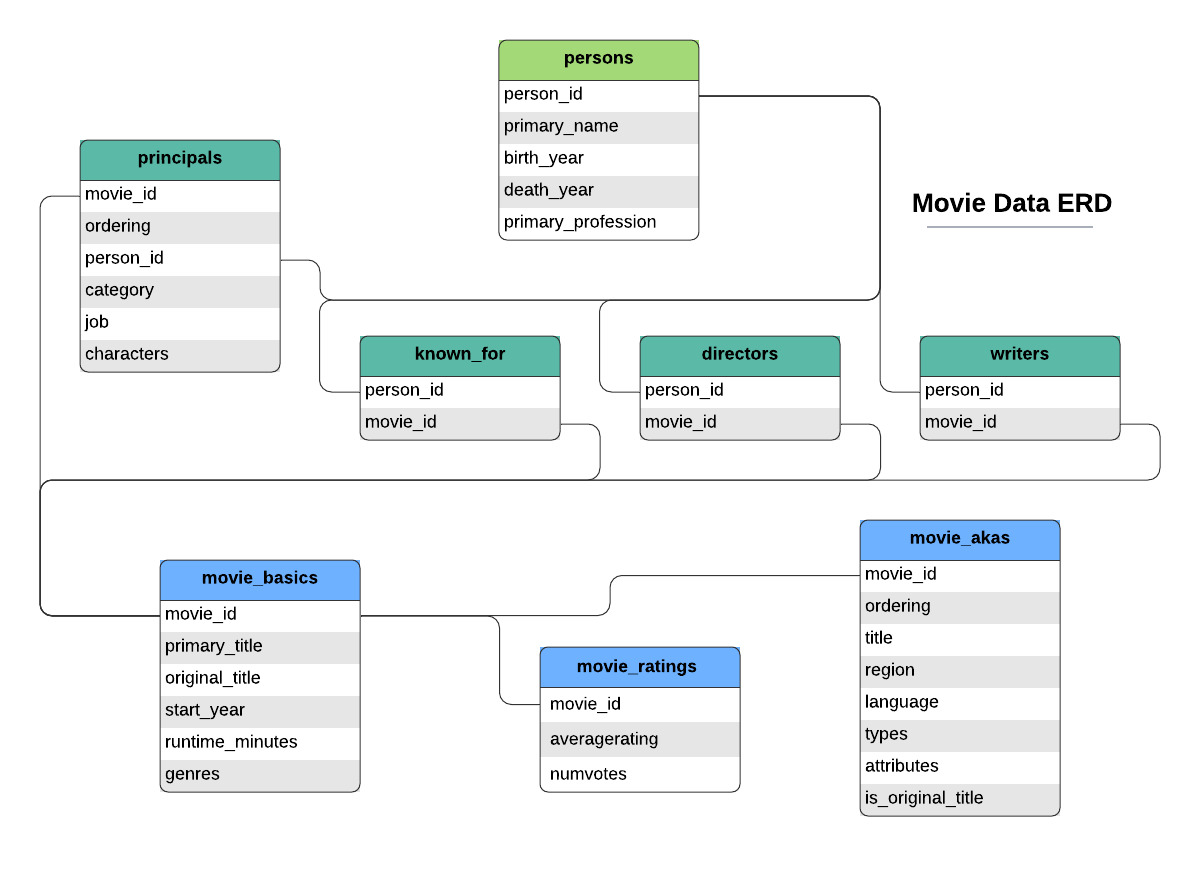

In [6]:
### Sort the directors by average rating and number of number
pd.read_sql("""SELECT  persons.primary_name AS 'Director Name' , AVG(averagerating) AS 'Average Rating', COUNT(movie_id) AS 'Number of Movies'
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
JOIN directors
    USING (movie_id)
JOIN persons
    USING (person_id)

GROUP BY persons.primary_name
ORDER BY AVG(averagerating) DESC
LIMIT 5
""", conn)
### We only care about high rated movies and directors with at least above average of movies ###

,Director Name,Average Rating,Number of Movies
0,Tristan David Luciotti,10.0,1
1,Stephen Peek,10.0,1
2,Michiel Brongers,10.0,1
3,Masahiro Hayakawa,10.0,1
4,Loreto Di Cesare,10.0,2


### Conclusion
All the dataset are usable other than the Rotten Tomatoes datasets.
We will be using the genre and popularity of the The Movie DB, the budget and gross profit of The Numbers, and the movie director info from IMBD. 
Some cleaning and filtering will be needed to make the data ready for analysis

## Data Preperation
Prepare the data for plotting and analysis

### The Moive DB
Dropping Unnamed column and remove duplicates are removed and we formatted the genre list so that it is readable.

In [7]:
####   Data Cleaning    ###
df_1['Unnamed: 0']    #No use, index column
df_1.drop("Unnamed: 0", axis = 1, inplace= True)   #Remove the column
###    Remove dups    ###
df_1.drop_duplicates(inplace = True)    #Remove dups
#Clean the list a bit
df_1['genre_ids'] = dp.clean_genre(df_1)

In [8]:
#Sort by popularity to see whats type of movies are the best and the worst
df_1.sort_values('popularity', inplace = True,ascending= False)    #Only care about the most popular movies
df1_top_movies = df_1[0:100]    #Top 100 movies 
df1_worst_movie = df_1[-100:]    #Worst 100 movies

### The Number
Nothing to removed. Budget and Gross Income are changed for statistical purposes. A ratio column is created to see how much profit the movie made. <br>
Ratio = Production Budget / Domestic Gross (Production Budget / Foriegn Gross)

In [9]:
# Clean up the budget from string to int
df_2['production_budget'] = dp.clean_df(df_2['production_budget'])
df_2['domestic_gross'] = dp.clean_df(df_2['domestic_gross'])
df_2['worldwide_gross'] = dp.clean_df(df_2['worldwide_gross'])

In [10]:
###   Make the ratio for both the profit
df_2['prod_dom_ratio'] = df_2['domestic_gross'] / df_2['production_budget']    #Ratio on the more proftitable movie - Domestic
df_2['prod_world_ratio'] = df_2['worldwide_gross'] / df_2['production_budget']    #Ratio on the more proftitable movie - worldwide
###    Production vs Domestic Ratio    ###
df_2.sort_values(['prod_dom_ratio'], ascending= False, inplace= True)
df2_most_prof = df_2['movie'].loc[df_2['prod_dom_ratio'] > 1]
df2_most_prof_2 = df_2['movie'].loc[df_2['prod_dom_ratio'] > 2]
df2_most_prof_3 = df_2['movie'].loc[df_2['prod_dom_ratio'] > 3] 
###    Production vs WorldWide Ratio    ###
df_2.sort_values(['prod_world_ratio'], ascending= False, inplace= True)
df2_most_prof_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 1]  
df2_most_prof_2_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 2]  
df2_most_prof_3_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 3]  

#### Categorical Data
Make the ratio into categories to see if that is easier to interpret

In [11]:
df_2['cat_f'] = df_2['prod_world_ratio'].map(lambda x: dp.cat_ratio(x))

In [12]:
zero_cat = len(df_2.loc[df_2['cat_f'] == 0])
one_cat = len(df_2.loc[df_2['cat_f'] == 1])
two_cat = len(df_2.loc[df_2['cat_f'] == 2])
three_cat = len(df_2.loc[df_2['cat_f'] == 3])
print("""
{:.0%} have a ratio of less than 1
{:.0%} have a ratio of 1 to 2
{:.0%} have a ratio of 2 to 3
{:.0%} have a ratio of more than 3
""".format(zero_cat/5782, one_cat/5782, two_cat/5782, three_cat/5782))

### Too screwed due to outliers?
print('Average production budget with ratio less than 1: ', df_2['production_budget'].loc[df_2['cat_f'] == 0].mean())
print('Average production budget with ratio between 1 and 2: ', df_2['production_budget'].loc[df_2['cat_f'] == 1].mean())
print('Average production budget with ratio between 2 and 3: ', df_2['production_budget'].loc[df_2['cat_f'] == 2].mean())
print('Average production budget with ratio over 3: ', df_2['production_budget'].loc[df_2['cat_f'] == 3].mean())



37% have a ratio of less than 1
18% have a ratio of 1 to 2
13% have a ratio of 2 to 3
32% have a ratio of more than 3

Average production budget with ratio less than 1:  19782161.38964706
Average production budget with ratio between 1 and 2:  39525991.26061776
Average production budget with ratio between 2 and 3:  46411044.962091506
Average production budget with ratio over 3:  34563546.463900864


In [13]:
df_2['production_budget'].std()
IQR = df_2['production_budget'].quantile(.75) - df_2['production_budget'].quantile(.25)
min_out = df_2['production_budget'].median() - IQR*1.5
max_out = df_2['production_budget'].median() + IQR*1.5
print(max_out)
outlier_removed = df_2.loc[df_2['production_budget'] < max_out]
outlier_removed['production_budget'].std()

69500000.0


17384352.59963998

In [14]:
print('Average production budget with ratio less than 1: ', outlier_removed['production_budget'].loc[outlier_removed['cat_f'] == 0].mean())
print('Average production budget with ratio between 1 and 2: ', outlier_removed['production_budget'].loc[outlier_removed['cat_f'] == 1].mean())
print('Average production budget with ratio between 2 and 3: ', outlier_removed['production_budget'].loc[outlier_removed['cat_f'] == 2].mean())
print('Average production budget with ratio over 3: ', outlier_removed['production_budget'].loc[outlier_removed['cat_f'] == 3].mean())


Average production budget with ratio less than 1:  15383520.633648582
Average production budget with ratio between 1 and 2:  23822085.117852975
Average production budget with ratio between 2 and 3:  24905965.37142857
Average production budget with ratio over 3:  17213876.295801528


#### The Movie DB and The Number
Combine the two dataset to see the correlation between the genre and the most profitable movies

In [15]:
# Titles from the first dataset
df1_top_list = list(df1_top_movies['title'])    #Top 100 movies from the first dataset
   
df1_top_genre = dp.count_genre(df1_top_movies)    #Top genre from the most popular movies
df1_worst_genre = dp.count_genre(df1_worst_movie)    #Top genre from teh worst movies

###    Function that takes the data frame, takes the movie name if they are also in the top movie list    ###
def list_of_movies(df_list):
    movie_list = []    #Make a empty list
    for name in df_list:    #For each movie in the list    
        for top in df1_top_list:    #Check if any of the most popular list are in the second list
            if(name == top):    #If match
                movie_list.append(name)     #Add the list
    return movie_list      


In [16]:
###    Over_# is the list of genre based on the movies with the respective ratios
###    If the movie is also in the most profitable list and the most popular list,
###    they count the genre for that ratio
over_1 = dp.count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof))])
over_2 = dp.count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_2))])
over_3 = dp.count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_3))])

over_1_w = dp.count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_world))])
over_2_w = dp.count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_2_world))])
over_3_w = dp.count_genre(df_1.loc[df_1['title'].isin(list_of_movies(df2_most_prof_3_world))])

all_genre = dp.count_genre(df_1)

In [17]:
movie_less_1_n_med = len(df_2['movie'].loc[(df_2['prod_world_ratio'] < 1) & (df_2['production_budget'] < 20000000.0)])
movie_less_1= len(df_2['movie'].loc[(df_2['prod_world_ratio'] > 1) & (df_2['production_budget'] < 20000000.0)])
movie_more_1_n_med = len(df_2['movie'].loc[(df_2['prod_world_ratio'] < 1) & (df_2['production_budget'] > 20000000.0)])
movie_more_1= len(df_2['movie'].loc[(df_2['prod_world_ratio'] > 1) & (df_2['production_budget'] > 20000000.0)])

movie_less_1_n_42 = len(df_2['movie'].loc[(df_2['prod_world_ratio'] < 1) & (df_2['production_budget'] < 42000000.0)])
movie_less_1_42= len(df_2['movie'].loc[(df_2['prod_world_ratio'] > 1) & (df_2['production_budget'] < 42000000.0)])
movie_more_1_n_42 = len(df_2['movie'].loc[(df_2['prod_world_ratio'] < 1) & (df_2['production_budget'] > 42000000.0)])
movie_more_1_42= len(df_2['movie'].loc[(df_2['prod_world_ratio'] > 1) & (df_2['production_budget'] > 42000000.0)])

world_movie_under_1 = len(df_2['movie'].loc[df_2['prod_world_ratio'] <= 1])
world_movie_over_1 = len(df2_most_prof_world)

In [18]:
print("Highest Worldwide Grossing movies all have higher than 3 ratio?", over_1_w == over_2_w == over_3_w)
print("""Number of movies with a ratio of 1 and above? 
      Domestic: {}, Foreign: {} """.format(len(df2_most_prof),len(df2_most_prof_world)))
print("""Number of movies with a ratio of 2 and above? 
      Domestic: {}, Foreign: {} """.format(len(df2_most_prof_2),len(df2_most_prof_2_world)))
print("""Number of movies with a ratio of 3 and above? 
      Domestic: {}, Foreign: {} """.format(len(df2_most_prof_3),len(df2_most_prof_3_world)))
print("""Number of movies with a ratio of under 1? 
      Domestic: {}, Foreign: {} """.format(len(df_2['movie'].loc[df_2['prod_dom_ratio'] <= 1]),world_movie_under_1))
print("""
{} movies out of {} have a ratio of < 1 with a budget less than 20000000
{} movies out of {} have a ratio of < 1 with a budget less than 42000000
{} movies out of {} have a ratio of < 1 with a budget more than 42000000
""".format(movie_less_1_n_med, world_movie_under_1,movie_less_1_n_42,world_movie_under_1,movie_more_1_n_42, world_movie_under_1 ))
print("""
{} movies out of {} have a ratio of > 1 with a budget less than 20000000
{} movies out of {} have a ratio of > 1 with a budget less than 42000000
{} movies out of {} have a ratio of > 1 with a budget more than 42000000
""".format(movie_less_1, world_movie_over_1,movie_less_1_42,world_movie_over_1,movie_more_1_42, world_movie_over_1 ))
print("""
{} movies out of {} have a ratio of > 1 with a budget more than 20000000

""".format(movie_more_1,len(df2_most_prof_world)))

Highest Worldwide Grossing movies all have higher than 3 ratio? False
Number of movies with a ratio of 1 and above? 
      Domestic: 2677, Foreign: 3657 
Number of movies with a ratio of 2 and above? 
      Domestic: 1492, Foreign: 2619 
Number of movies with a ratio of 3 and above? 
      Domestic: 942, Foreign: 1855 
Number of movies with a ratio of under 1? 
      Domestic: 3105, Foreign: 2125 

1377 movies out of 2125 have a ratio of < 1 with a budget less than 20000000
1833 movies out of 2125 have a ratio of < 1 with a budget less than 42000000
284 movies out of 2125 have a ratio of < 1 with a budget more than 42000000


1689 movies out of 3657 have a ratio of > 1 with a budget less than 20000000
2580 movies out of 3657 have a ratio of > 1 with a budget less than 42000000
1058 movies out of 3657 have a ratio of > 1 with a budget more than 42000000


1821 movies out of 3657 have a ratio of > 1 with a budget more than 20000000




In [19]:
#Determine a reasonable range of budget that gives the most benifical ratio possible
df_2.sort_values(['production_budget'], ascending= False, inplace= True)
IQR = df_2['prod_world_ratio'].quantile(.75) - df_2['prod_world_ratio'].quantile(.25)
min_out = df_2['prod_world_ratio'].median() - IQR*1.5
max_out = df_2['prod_world_ratio'].median() + IQR*1.5

outlier_removed = df_2.loc[df_2['prod_world_ratio'] < 6.607385548232989]
outlier_removed['prod_world_ratio'].describe()
scat_x = outlier_removed['production_budget'].loc[outlier_removed['prod_world_ratio'] > 1]
scat_y = outlier_removed['prod_dom_ratio'].loc[outlier_removed['prod_world_ratio'] > 1]
outlier_removed['prod_world_ratio'].median()
outlier_removed['production_budget'].quantile(.75)

42000000.0

### IMDB
Database that has alot of information so will be only focusing on director

In [20]:
dv.read_sql(conn)

,Director Name,Number of Movies
0,A Normale Jef,46
1,A'Ali de Sousa,1
2,A. Blaine Miller,1
3,A. Cengiz Mert,1
4,A. Fishman,1


In [21]:
list_of_directors = dv.top_directors(conn)

In [22]:
Recommended_dir = dv.top_dir_and_movies(conn)

## Data Analysis

### Best and Worst Movie Genre
The most popular movies genres were action, adventure, sci-fi and fantasy. <br>
The worst movie genre were documentary, comedy and movie with no genre listed (too short, too vague) <br>
Drama was seen in both the worst and the best genre which may be the result of the genre being combined with others.
The most used genre aren't the most popular and should be advise to use one of the best performing genre instead. 

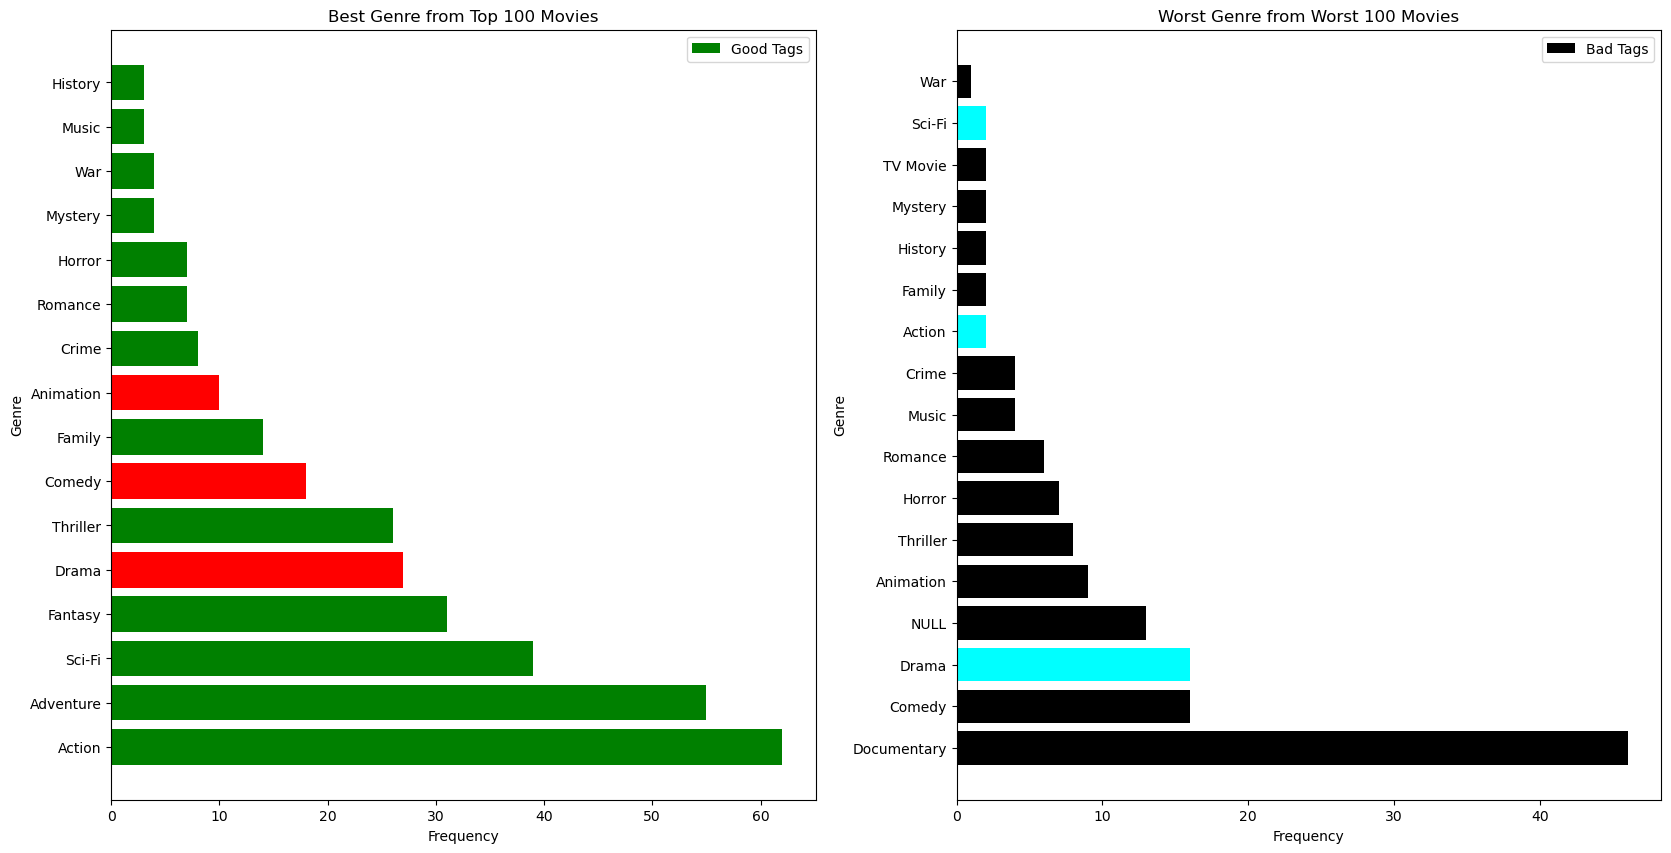

In [25]:
dv.worst_and_best(df1_top_genre, df1_worst_genre)

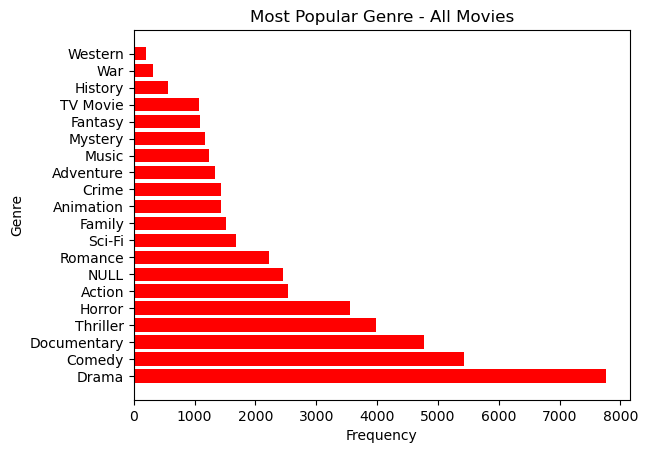

In [26]:
dv.top_genre(all_genre)

### Most Profitable Genre 
Domestically, there was a pretty broad range of genre that resulted in a higher ratio. 
Internationally, there was a clear difference and the data lined up almost one to one, where the most popular genres were also the most profitable. Other genres may perform better domestical but fall behind the top genre internationally.

#### Domestic Gross


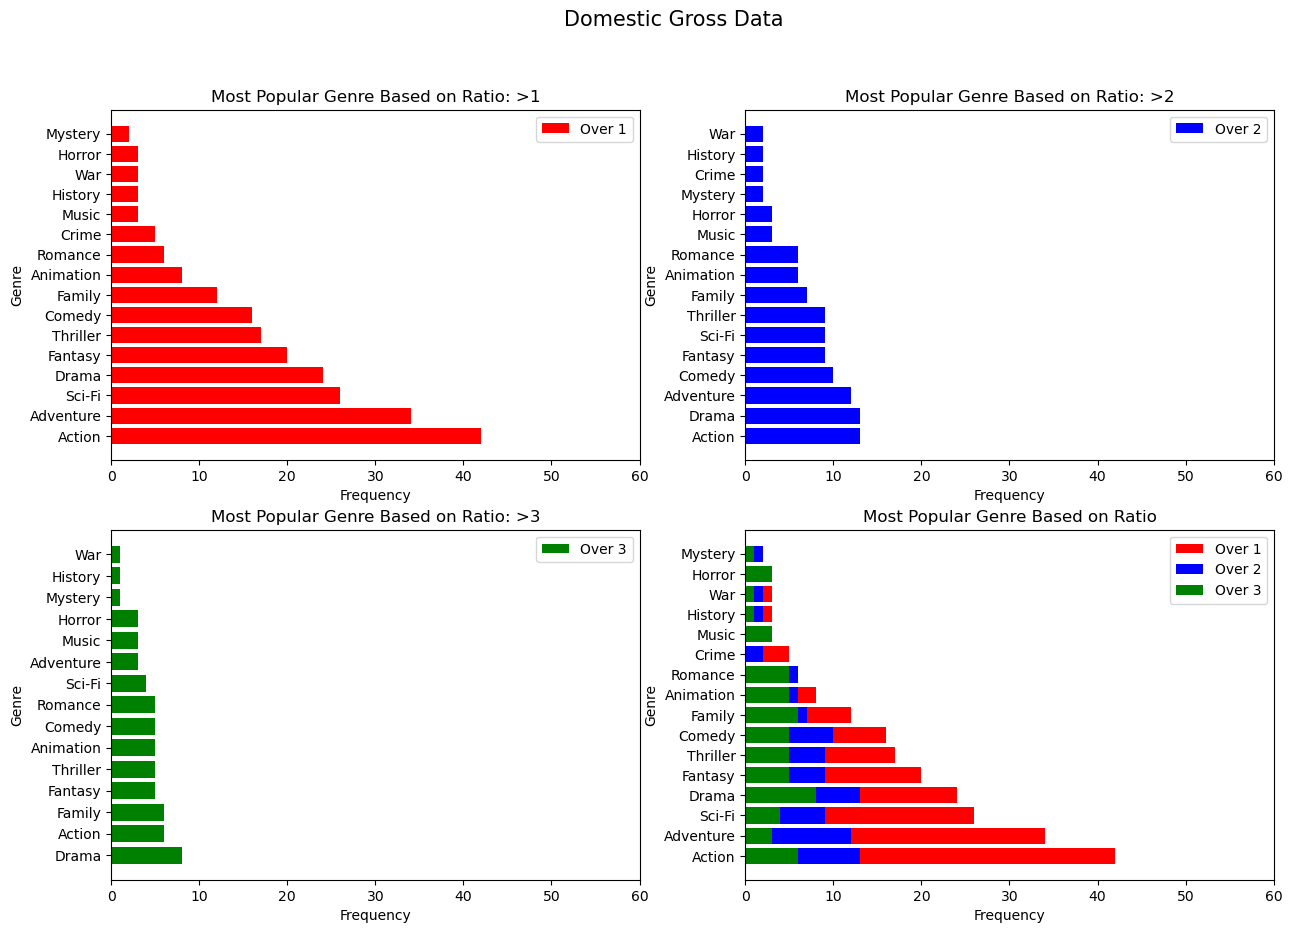

In [27]:
dv.genre_comparison('Domestic Gross Data' ,over_1, over_2, over_3)

#### Foreign Gross

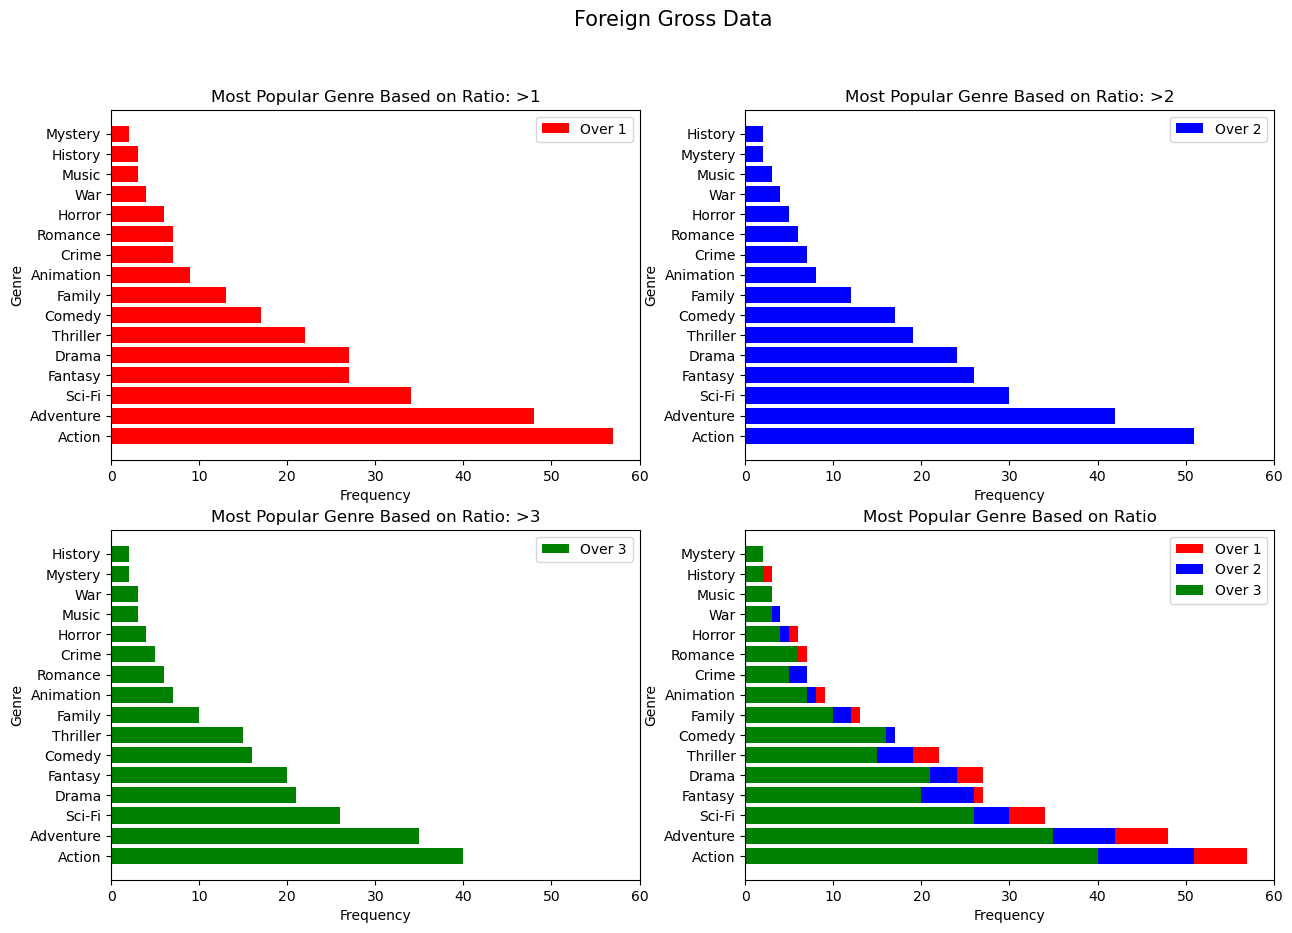

In [28]:
dv.genre_comparison('Foreign Gross Data',over_1_w, over_2_w, over_3_w)

### Movie Gross to Production Ratio

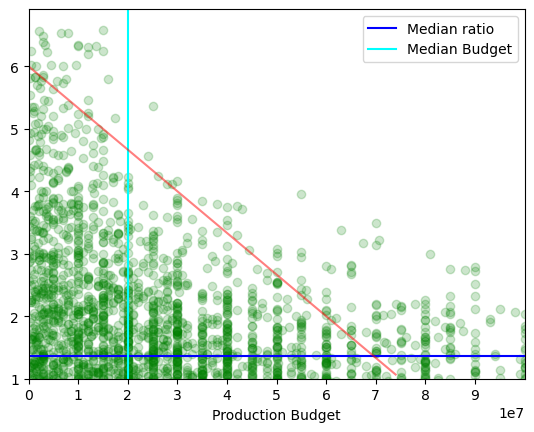

In [29]:
fig, ax = plt.subplots()
ax.scatter(scat_x, scat_y , alpha= .2, color = 'green')
#line = plt.axvline(200000000, color = 'red');
ax.set_xlabel('Production Budget')
ax.set_xticks(list(range(0,100000000,10000000)));

#ax.set_xticks([0,10000000,20000000]);
ax.set_xlim(0,100000000)
ax.set_ylim(1)
x = list(range(0,74000000,1000))
y = [6-x2/15000000 for x2 in x]
ax.axhline(outlier_removed['prod_world_ratio'].median() , color = 'blue', label = 'Median ratio');
ax.axvline(outlier_removed['production_budget'].median(),color = 'cyan', label = 'Median Budget')
ax.legend()
ax.plot(x, y, color = 'red', alpha = .5)

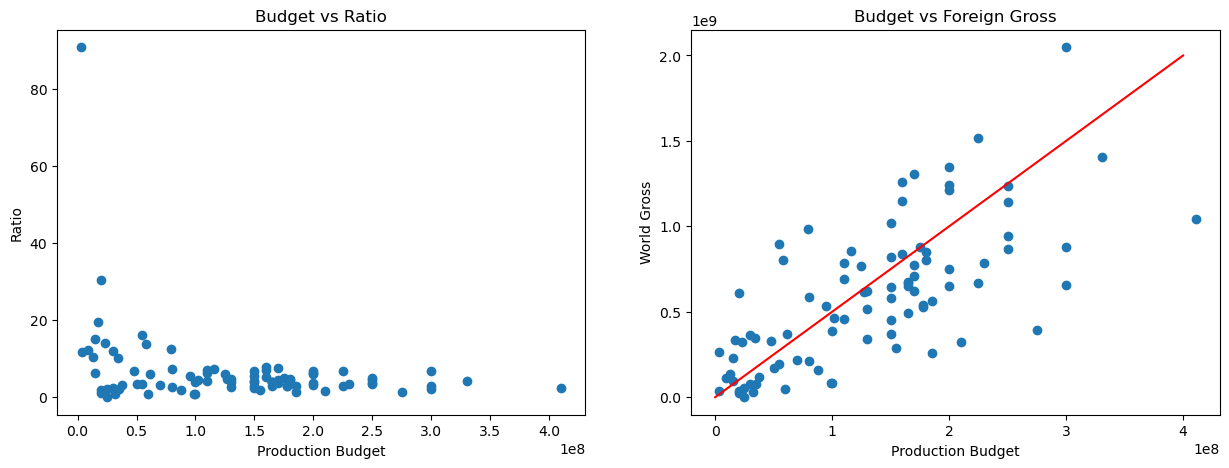

In [30]:
df1_and_2 = df_2.loc[df_2['movie'].isin(df1_top_movies['title'])]    #See what kind of trend the top movies have
dv.graph_budgets(df1_and_2)

In [ ]:
Recommended_dir
set(Recommended_dir['Director Name'])